In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools


from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_15644/3188123076.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


imblearn version:  0.12.0


# Plotting Functions

In [2]:
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
def plot_heatmap(dist, observed_pred, probabilities, title): 
    pred_samples = dist.sample(torch.Size((100,))).exp()
    title = str(title)
    # probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
    probabilities_np = probabilities.numpy()
    class0_prob = probabilities_np[0, :]
    class1_prob = probabilities_np[1, :]
    
    num_samples = class0_prob.shape[0]
    side_length = int(np.ceil(np.sqrt(num_samples)))
    grid_data_class0 = np.full((side_length, side_length), np.nan)
    grid_data_class0.flat[:num_samples] = class0_prob
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].imshow(grid_data_class0, cmap='RdYlGn', origin='lower', aspect='equal')
    ax[0].set_title('Probability of Class 0 - '+title)
    ax[0].axis('off');
    fig.colorbar(ax[0].imshow(grid_data_class0, cmap='RdYlGn', origin='lower', aspect='equal'), ax=ax[0], label='Class 0')
    
    # Class 1 
    grid_data_class1 = np.full((side_length, side_length), np.nan)
    grid_data_class1.flat[:num_samples] = class1_prob
    ax[1].imshow(grid_data_class1, cmap='RdYlGn', origin='lower', aspect='equal')
    ax[1].set_title('Probability of Class 1 - '+title)
    ax[1].axis('off')
    fig.colorbar(ax[1].imshow(grid_data_class1, cmap='RdYlGn', origin='lower', aspect='equal'), ax=ax[1], label='Class 1')
    fig.suptitle('nek2 inhibition generated probabilities from posterior distribution- '+title)
    plt.savefig('nek2_inhib_probabilities_'+title+'.png')
    plt.show();

In [50]:
def plot_tsne(input, y_true, n_components): 
    tsne = TSNE(n_components=n_components, random_state=42)
    embedded_data = tsne.fit_transform(input)
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=y_true, cmap='viridis')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Labels')
    plt.show();

In [5]:
def plot_hist(observed_pred, title): 
    var = observed_pred.variance.numpy().tolist()
    # plot class 0 and class 1 sep
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    class0_var = observed_pred.variance[0].numpy()
    class1_var = observed_pred.variance[1].numpy()
    # class 0 
    
    sns.histplot(class0_var, bins=20, kde =True,color ='blue', ax=ax[0])
    # sns.kdeplot(class0_var, color='red', ax=ax[0])
    ax[0].set_title(f'Class 0 Variance Distribution')
    ax[0].set_xlabel('Variance')
    ax[0].set_ylabel('Density')
    ax[0].grid(True)


    # class 1
    sns.histplot(class1_var, bins=20, kde =True, color='green',ax=ax[1])
    # sns.kdeplot(class1_var, color='orange', ax=ax[1])
    ax[1].set_title(f'Class 1 Variance Distribution')
    ax[1].set_xlabel('Variance')
    ax[1].set_ylabel('Density')
    ax[1].grid(True)


    plt.suptitle('Inhibition Distribution of Variances for Each Class -' + title)
    plt.legend()
    plt.grid(True) 
    plt.tight_layout()  
    plt.savefig(f'nek2_inhib_variance_dist_{title}.png')
    plt.show();

In [6]:
def plot_hist_tp_tn(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, true_pos].numpy()

    plt.figure(figsize=(10,6))
    plt.hist(var_tp, bins=10, alpha=0.5, density=True, label = 'True Positive')
    plt.hist(var_tn, bins=10, alpha=0.5, density=True, label = 'True negative')
    # print(f'tp var: {var_tp}')
    # print(f'tn var: {var_tn}')
    plt.xlabel('Variance')
    plt.legend()
    plt.ylabel('Density')
    plt.title(f'Inhibition Variance Distribution for TP and TN - {title}')
    plt.grid(True)
    plt.savefig(f'nek2_inhib_variance_dist_tp_tn_{title}.png')
    plt.show();

In [7]:
def plot_cm_dist(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    print(f'predictions shape: {predictions.shape}')
    print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 4)
    plt.hist(var_tp, color='green', alpha=0.7)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 1)
    plt.hist(var_tn, color='blue', alpha=0.7)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 3)
    plt.hist(var_fp, color='red', alpha=0.7)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 2)
    plt.hist(var_fn, color='orange', alpha=0.7)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'Inhibition Variance Distribution of Predictions {title}', fontsize=14, y=1.05)

    plt.savefig(f'nek2_inhib_var_dist_tptnfpfn_{title}.png')

    plt.show();

In [56]:
def plot_cm_dist_kde(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    print(f'predictions shape: {predictions.shape}')
    print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 4)
    sns.histplot(var_tp, kde=True,color='green', bins=10)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 1)
    sns.histplot(var_tn, kde=True,color='blue', bins=10)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 2)
    sns.histplot(var_fp, kde=True,color='red', bins=10)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 3)
    sns.histplot(var_fn, kde=True, color='orange', bins=10)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'Inhibition Variance Distribution of Predictions {title}', fontsize=14, y=1.05)

    plt.savefig(f'nek2_inhib_var_dist_tptnfpfn_kde{title}.png')

    plt.show();

In [54]:
def plot_cm_dist_kde_scaled(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    print(f'predictions shape: {predictions.shape}')
    print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()


    plt.figure(figsize=(10, 10))

    
    ax2 = plt.subplot(2, 2, 1)
    sns.histplot(var_tn, kde=True,color='blue', bins=10, ax=ax2)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')


    ax1 = plt.subplot(2, 2, 4, sharey=ax2)
    # plt.subplot(2, 2, 4)
    sns.histplot(var_tp, kde=True,color='green', bins=10, ax=ax1)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')
    plt.ylim(0, 5)

    ax3 = plt.subplot(2, 2, 2, sharey=ax2)
    sns.histplot(var_fp, kde=True,color='red', bins=10, ax=ax3)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')
    
    ax4 = plt.subplot(2, 2, 3, sharey=ax2)
    sns.histplot(var_fn, kde=True, color='orange', bins=10,ax=ax4)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'NEK2 Inhibition Variance Distribution Scaled - {title}', fontsize=14, y=1.05)

    plt.savefig(f'nek2_inhib_cm_kdehist_scaled{title}.png')

    plt.show();

In [9]:
def plot_violin(observed_pred, title, class_labels = ['0', '1'],y_max = 10): 
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))


    class0_var = observed_pred.variance[0].numpy() 
    # plt.hist(class0_var, bins=20, alpha=0.5, label=f'Class 0')

    class1_var = observed_pred.variance[1].numpy() 
    # plt.hist(class1_var, bins=20, alpha=0.5, label=f'Class 1')
    sns.violinplot(data=var, inner="quartile")
    # sns.violinplot(data=var, inner="quartile", hue=class_labels)
    sns.violinplot(x='Class', y='Variance', data=df)
  
    plt.set_xlabel('Class')

    plt.grid(True)

    
    # sns.violinplot(data=class1_var.tolist(), inner="quartile")
    # plt.xlabel('Class')

    plt.ylabel('Variance')
    # plt.ylim(0,y_max)
    plt.legend()
    plt.title(f'Inhibition Variance Distribution - {title}')
    plt.grid(True)
    plt.savefig(f'nek2_inhib_violin_{title}.png')
    plt.show();

In [10]:
from sklearn.metrics import roc_curve, auc
def plot_roc(y_true, y_prob):
    y_prob0 = y_prob[0,:]
    y_prob1 = y_prob[1,:]
    fpr0, tpr0, thresholds0 = roc_curve(y_true, y_prob0)
    fpr1, tpr1, thresholds1 = roc_curve(y_true, y_prob1)
    roc_auc0 = auc(fpr0, tpr0)
    roc_auc1 = auc(fpr1, tpr1)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, color='orange', lw=2, label='class 1 ROC curve (area = %0.2f)' % roc_auc0)
    plt.plot(fpr0, tpr0, color='blue', lw=2, label='class 0 ROC curve (area = %0.2f)' % roc_auc0)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('NEK2 Inhibition ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'NEK2_inhib_roc_test.png')
    plt.show(); 


In [44]:
def plot_kde(observed_pred, title): 
    plt.figure(figsize=(8, 6))
    var = observed_pred.variance.numpy().tolist()
    class0_var = observed_pred.variance[0].numpy() 
    class1_var = observed_pred.variance[1].numpy() 
    
    sns.kdeplot(class0_var, label=f'Class 0')
    sns.kdeplot(class1_var, label=f'Class 1')
    plt.xlabel('Variance')
    plt.ylabel('Density')
    plt.title(f'Inhibition KDE Variances for Each Class - {title}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'nek2_inhib_kde_plot_{title}.png')
    plt.show();

In [12]:
def look_at_data(filepath):
    """5-fold on majority and minority separately, then concat into one df""" 
    df = pd.read_csv(filepath)

    print("Dataset shape:",df.shape)
    print(df.active.value_counts())
    print(df['fold'].unique())
    num_gap = (df.loc[df['active']==0].shape[0]) - (df.loc[df['active']==1].shape[0])
    print("\nDifference in class sample sizes: ",num_gap)

    num_minority = df.loc[df['active']==1].shape[0]
    print("Number of minority samples: ",num_minority)
    # print(df.describe())
    print(f"active/inactive: {df['active'].value_counts()}")
    print(f"active/inactive: {df['active'].value_counts()}")
    counts_per_fold = df.groupby('fold')['active'].value_counts()
    print(counts_per_fold)
    return df

In [13]:
split_path = '../../../data/NEK_data_4Berkeley/NEK2/'
file = 'NEK2_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv'
all_fold_df = look_at_data(split_path+'NEK2_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv')

Dataset shape: (2044, 310)
active
0    1904
1     140
Name: count, dtype: int64
['fold4' 'fold1' 'fold2' 'fold3' 'fold5']

Difference in class sample sizes:  1764
Number of minority samples:  140
active/inactive: active
0    1904
1     140
Name: count, dtype: int64
active/inactive: active
0    1904
1     140
Name: count, dtype: int64
fold   active
fold1  0         381
       1          28
fold2  0         381
       1          28
fold3  0         381
       1          28
fold4  0         381
       1          28
fold5  0         380
       1          28
Name: count, dtype: int64


In [14]:
# train fold 1
split_path = "../../../data/datasets/NEK_data_4Berkeley/NEK2"
# /Users/jayceepang/msse/capstone/data/NEK_data_4Berkeley/NEK2/NEK2_binding_random_fold1_testY.csv

train_x_df_temp = pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_trainX.csv")
train_y_df_temp = pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_trainY.csv")
test_x_df = pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_testX.csv")
test_y_df = pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_testY.csv")

In [42]:
print(f"inactive shape: {train_y_df_temp[train_y_df_temp['active']==0].shape}")
print(f"active shape: {train_y_df_temp[train_y_df_temp['active']==1].shape}")

inactive shape: (1523, 1)
active shape: (112, 1)


In [41]:
# SMOTE: Adjust imbalanced training data

# transform the dataset
oversample = SMOTE()
new_train_x_df, new_train_y_df = oversample.fit_resample(train_x_df_temp, train_y_df_temp)

# display(new_train_x_df.head)

display("original training size: ",train_x_df_temp.shape)
# display(train_y_df_temp.value_counts())
display("SMOTE train set size:",new_train_x_df.shape)
# display(new_train_y_df.value_counts())



# SMOTE 
print(f"inactive shape: {new_train_y_df[new_train_y_df['active']==0].shape}")
print(f"active shape: {new_train_y_df[new_train_y_df['active']==1].shape}")


'original training size: '

(1635, 306)

'SMOTE train set size:'

(3046, 306)

inactive shape: (1523, 1)
active shape: (1523, 1)


In [43]:
1523*2

3046

In [16]:
# save to files 

train_x_df = new_train_x_df
train_y_df = new_train_y_df

train_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_inhibition_random_smote_fold1_trainX.csv", index=False)
train_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_inhibition_random_smote_fold1_trainY.csv", index=False)
test_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_inhibition_random_smote_fold1_testX.csv", index=False)
test_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_inhibition_random_smote_fold1_testY.csv", index=False)




In [17]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df) 


train_x_temp = train_scaled_data.astype("long")
test_x_temp = test_scaled_data.astype("long")

train_y_temp = train_y_df.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")


train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape) 
print(train_y.shape) 

torch.Size([3046, 306])
torch.Size([3046])


In [18]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




In [19]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 

            

    def predict(self, input): 
        # predict on validation set? 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # get predicted distributions 
            pred_means = dist.loc          # extract means for predicted dist
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood predictions 
            class_pred = self.model(input).loc.max(0)[1].numpy() 
        return dist, observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true, class_names, plot_name): 
        
        y_pred = self.model(x_input).loc.max(0)[1].numpy() 

        cm = confusion_matrix(y_true, y_pred)
        plt.rcParams.update({"font.size": 20})
        label_font = {'size':'18'} 
        ax = plt.figure(figsize=(5,5))
        plt.title(plot_name,fontsize=20)
        plot_confusion_matrix(cm, classes=class_names, normalize=False)
        plt.xlabel("Predicted",fontdict=label_font);
        plt.ylabel("Actual",fontdict=label_font);
        return y_pred
    
    
    def get_metrics(self, x, y_true, y_pred): 
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x)     # get predicted distributions 
        pred_means = dist.loc          # means for predicted dist 
        # pred_probs = self.likelihood(dist).probs #predicted probabilities 
        # f_mean = dist.mean
        # f_var = dist.variance
        # f_covar = dist.covariance_matrix
        # f_samples = dist.sample(sample_shape=torch.Size(1000))    
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        # # roc_auc = roc_auc_score(y_true, y_pred_proba) 
        # # fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
        # # roc_auc_curve = auc(fpr, tpr)
        # # precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
        # # pr_auc_curve = auc(recall, precision)
        
        
        return accuracy, precision, f1, recall 
            

In [23]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.062   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.813   lengthscale: 1.319   noise: 1.291
Iter 21/300 - Loss: 5.097   lengthscale: 2.197   noise: 1.874
Iter 31/300 - Loss: 4.590   lengthscale: 3.301   noise: 2.013
Iter 41/300 - Loss: 4.231   lengthscale: 4.404   noise: 1.605
Iter 51/300 - Loss: 3.967   lengthscale: 5.325   noise: 0.956
Iter 61/300 - Loss: 3.776   lengthscale: 6.024   noise: 0.444
Iter 71/300 - Loss: 3.655   lengthscale: 6.541   noise: 0.195
Iter 81/300 - Loss: 3.601   lengthscale: 6.924   noise: 0.102
Iter 91/300 - Loss: 3.571   lengthscale: 7.199   noise: 0.064
Iter 101/300 - Loss: 3.554   lengthscale: 7.396   noise: 0.047
Iter 111/300 - Loss: 3.540   lengthscale: 7.538   noise: 0.037
Iter 121/300 - Loss: 3.540   lengthscale: 7.646   noise: 0.030
Iter 131/300 - Loss: 3.530   lengthscale: 7.733   noise: 0.026
Iter 141/300 - Loss: 3.531   lengthscale: 7.807   noise: 0.023
Iter 151/300 - Loss: 3.530   lengthscale: 7.870   noise: 0.020
Ite

In [24]:
# get predictions of train x input
train_dist, train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
# print(f'pred means shape: {train_pred_means.numpy().shape}')
print(f'train predictions: {train_pred}')
print(f'train prediction means: {train_pred_means}')

print(train_pred_means.shape)
train_accuracy, train_precision, train_f1, train_recall = trainer1.get_metrics(train_x, train_y, train_pred)
print(f'accuracy: {train_accuracy}, precision: {train_precision}, f1: {train_f1}, recall: {train_recall}')
# plot_tsne(train_x, train_y, 3)

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


train predictions: [0 0 0 ... 1 1 1]
train prediction means: tensor([[-0.5609, -0.9826, -0.6286,  ..., -4.9018, -7.6176, -6.4077],
        [-5.6207, -4.7214, -5.2881,  ..., -0.6748,  0.1017, -0.0262]])
torch.Size([2, 3046])


/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


accuracy: 0.9983585029546946, precision: 0.9967277486910995, f1: 0.9983611930514585, recall: 1.0


Confusion matrix, without normalization
[[1518    5]
 [   0 1523]]


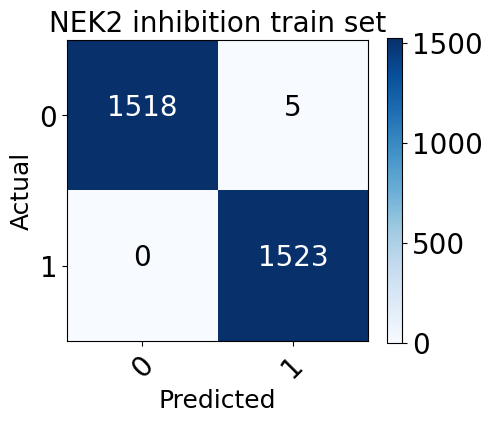

In [25]:
train_cm = confusion_matrix(train_y, train_pred)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 inhibition train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [26]:
# Make predictions on test set  
test_dist, test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)

# print(f'test predictions: {test_pred}')
# print(f'test prediction means: {test_pred_means}')
# print(test_pred_means.shape)
test_accuracy, test_precision, test_f1, test_recall = trainer1.get_metrics(test_x, test_y, test_pred)
print(f'accuracy: {test_accuracy}, precision: {test_precision}, f1: {test_f1}, recall: {test_recall}')


accuracy: 0.9559902200488998, precision: 0.7272727272727273, f1: 0.64, recall: 0.5714285714285714


Confusion matrix, without normalization
[[375   6]
 [ 12  16]]


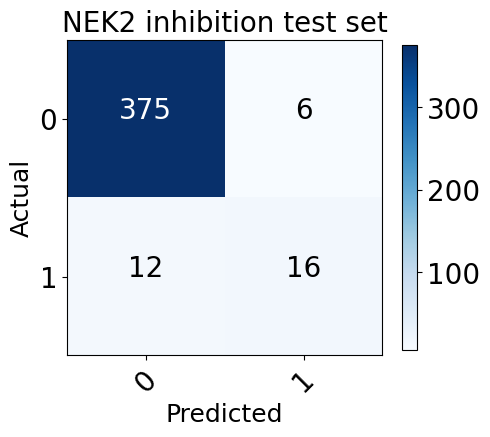

In [27]:
test_cm = confusion_matrix(test_y, test_pred)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 inhibition test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

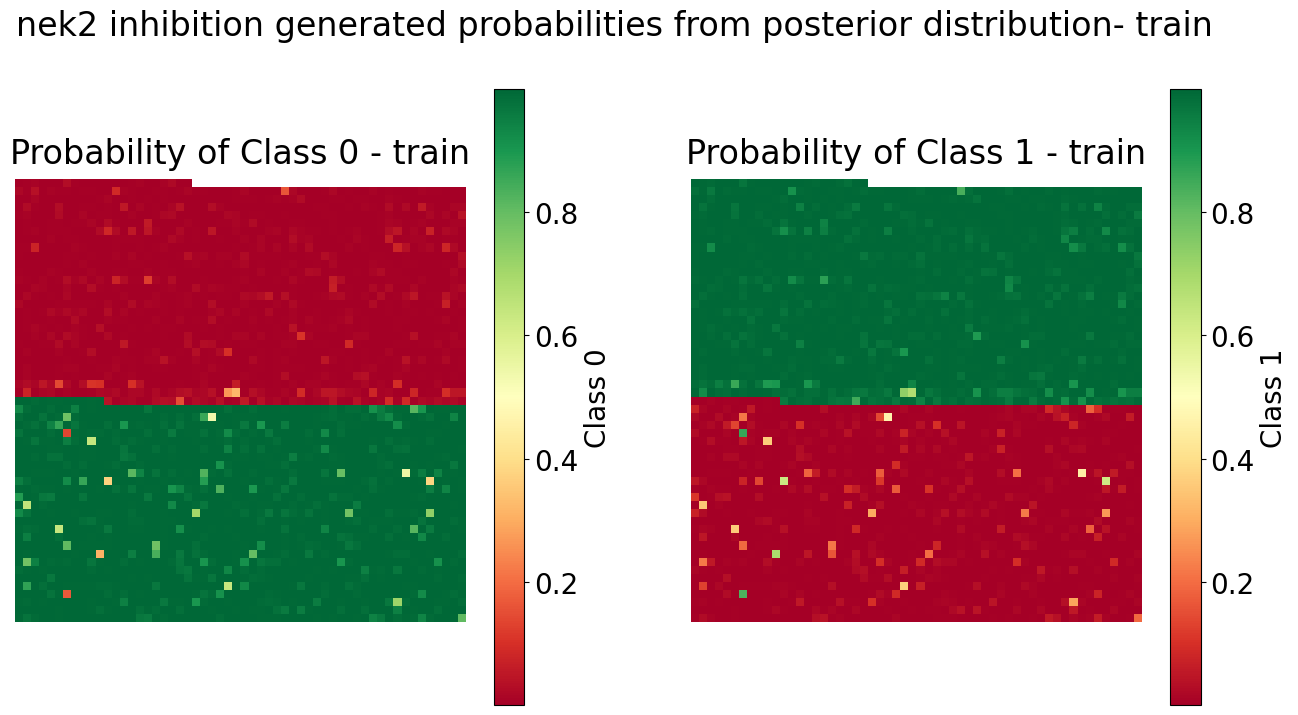

In [66]:
# get train samples 

train_pred_samples = train_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).mean(0)
train_probabilities.shape 
# TRAIN
plot_heatmap(train_dist, train_observed_pred, train_probabilities, 'train')

In [61]:
train_probabilities

tensor([[0.9936, 0.9778, 0.9895,  ..., 0.0098, 0.0078, 0.0024],
        [0.0064, 0.0222, 0.0105,  ..., 0.9902, 0.9922, 0.9976]])

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


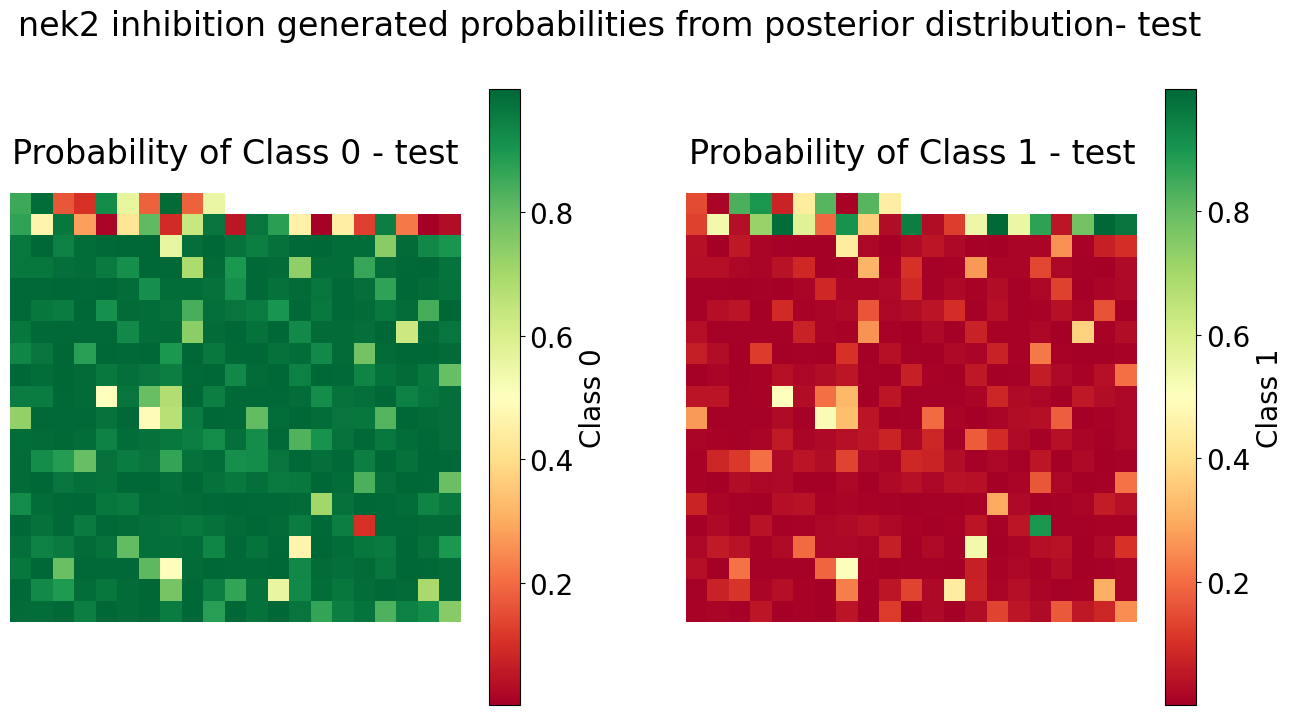

In [51]:
# TEST SET
# # Get confidence regions 
# confidence 
lower, upper = test_observed_pred.confidence_region()

# # Generate samples to get probabilities
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
plot_heatmap(test_dist, test_observed_pred, probabilities, 'test')

In [63]:
probabilities.shape

torch.Size([2, 409])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


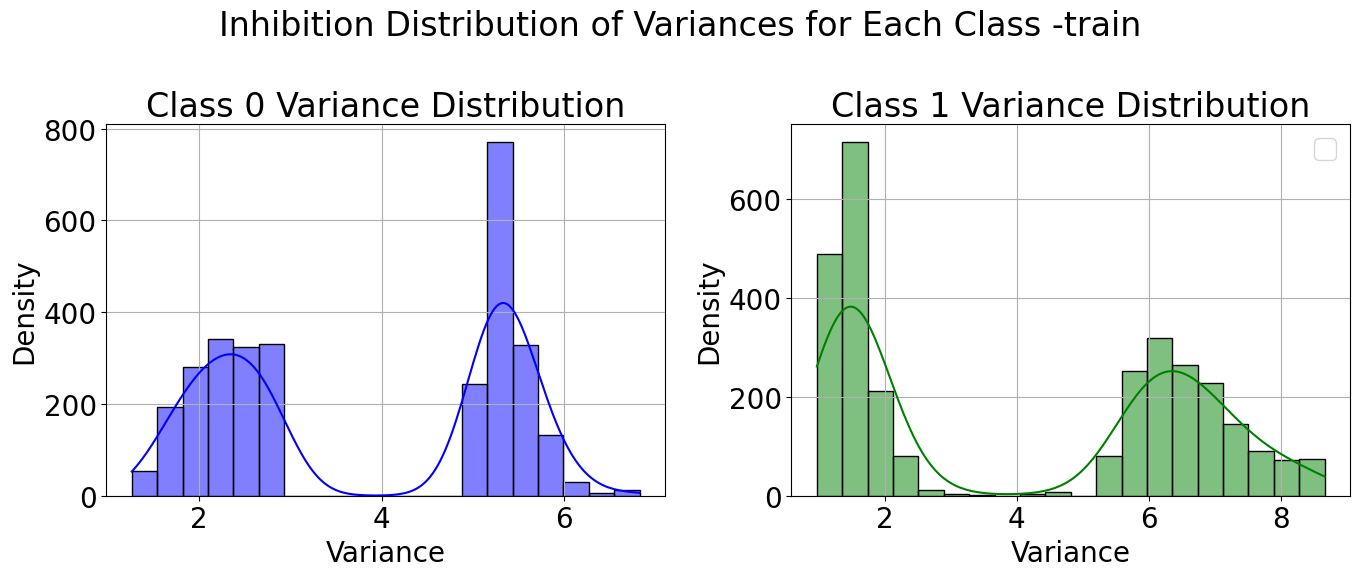

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


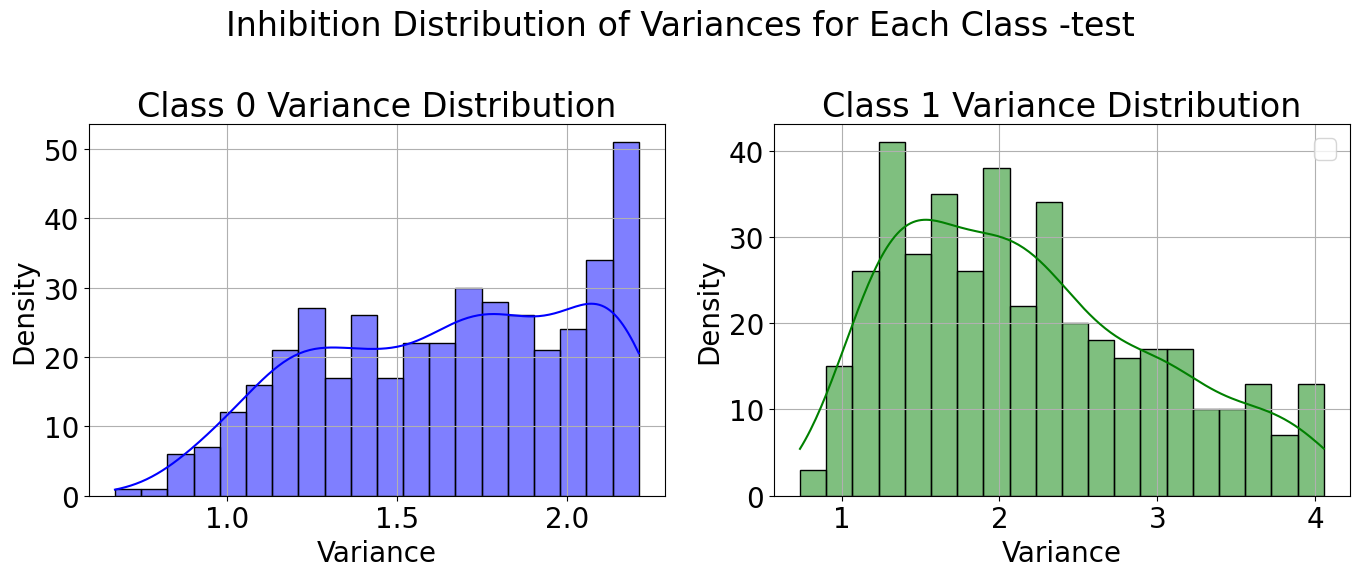

In [50]:
plot_hist(train_observed_pred, 'train')
plot_hist(test_observed_pred, 'test')

In [64]:
train_observed_pred.variance.max()

tensor(8.6644)

predictions shape: (3046,)
true labels shape: (3046,)


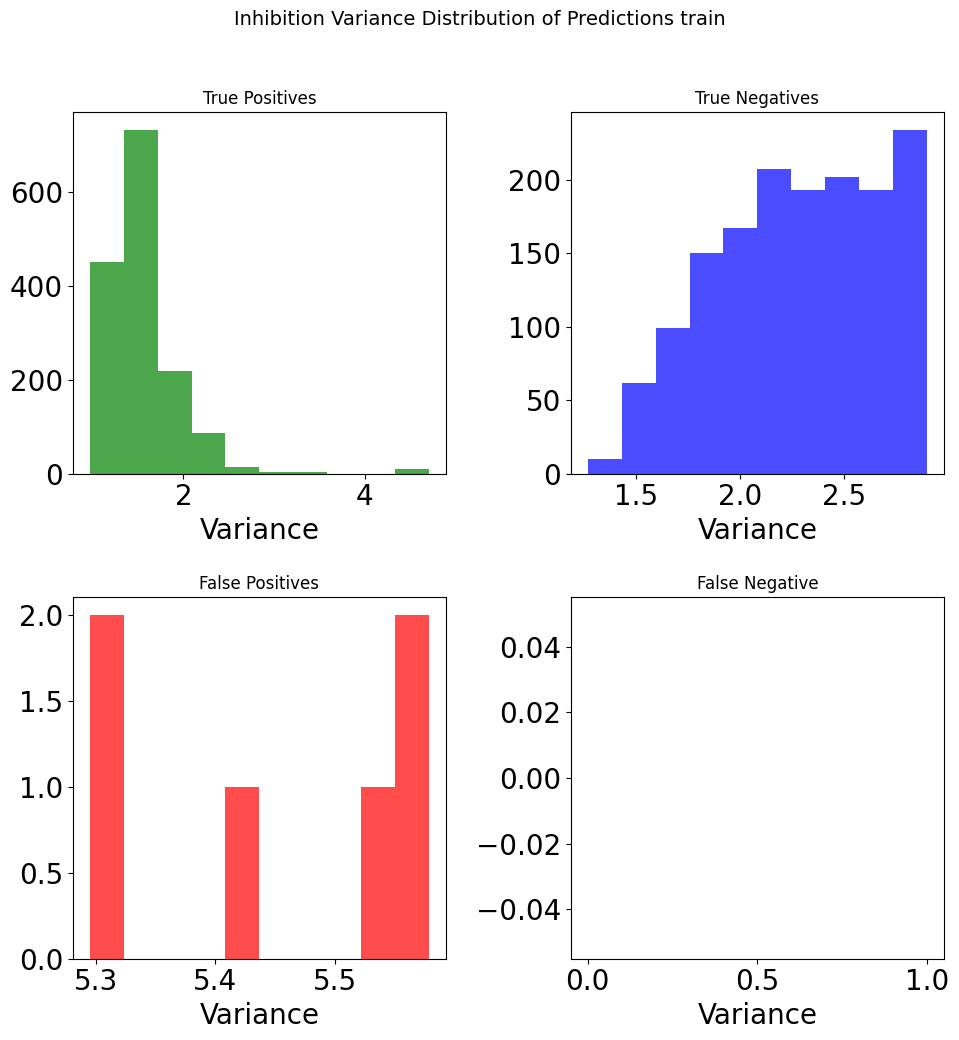

predictions shape: (409,)
true labels shape: (409,)


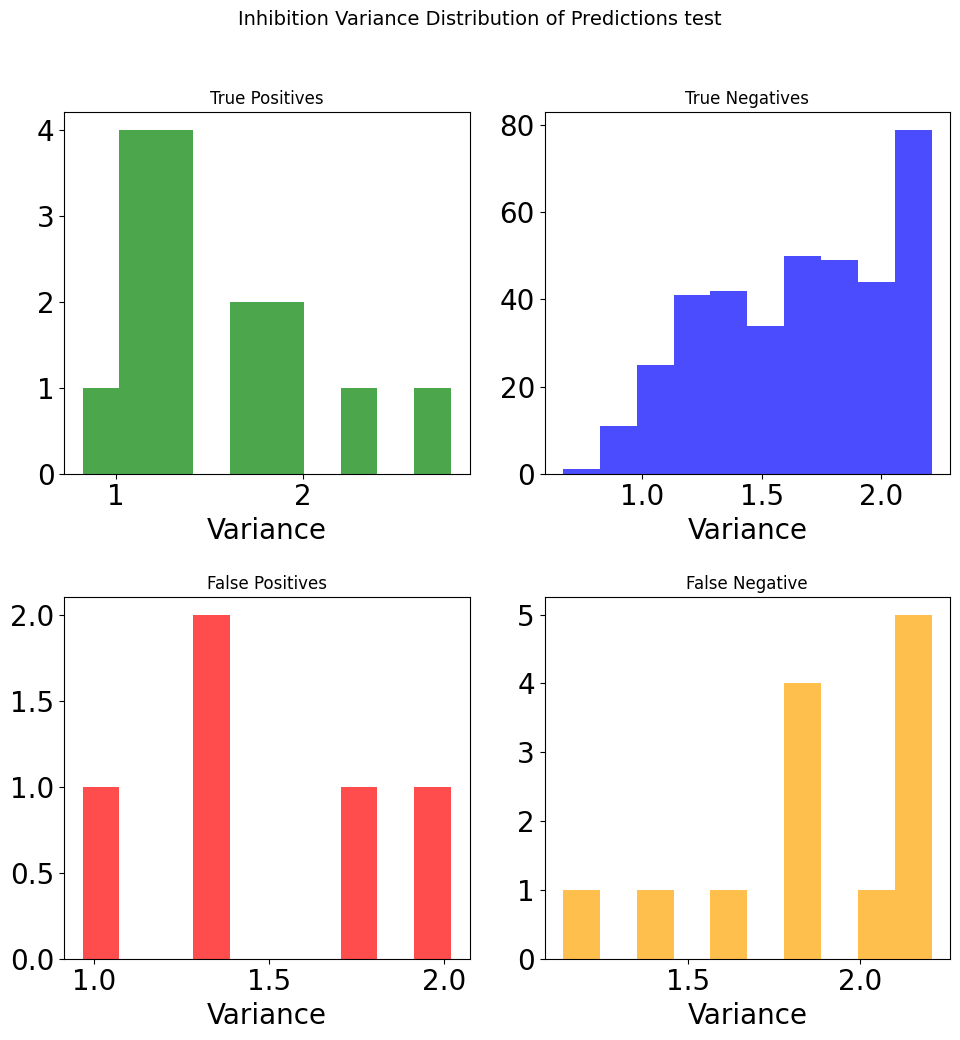

In [66]:
plot_cm_dist(train_observed_pred, train_pred, train_y, 'train')
plot_cm_dist(test_observed_pred, test_pred, test_y, 'test')


predictions shape: (3046,)
true labels shape: (3046,)


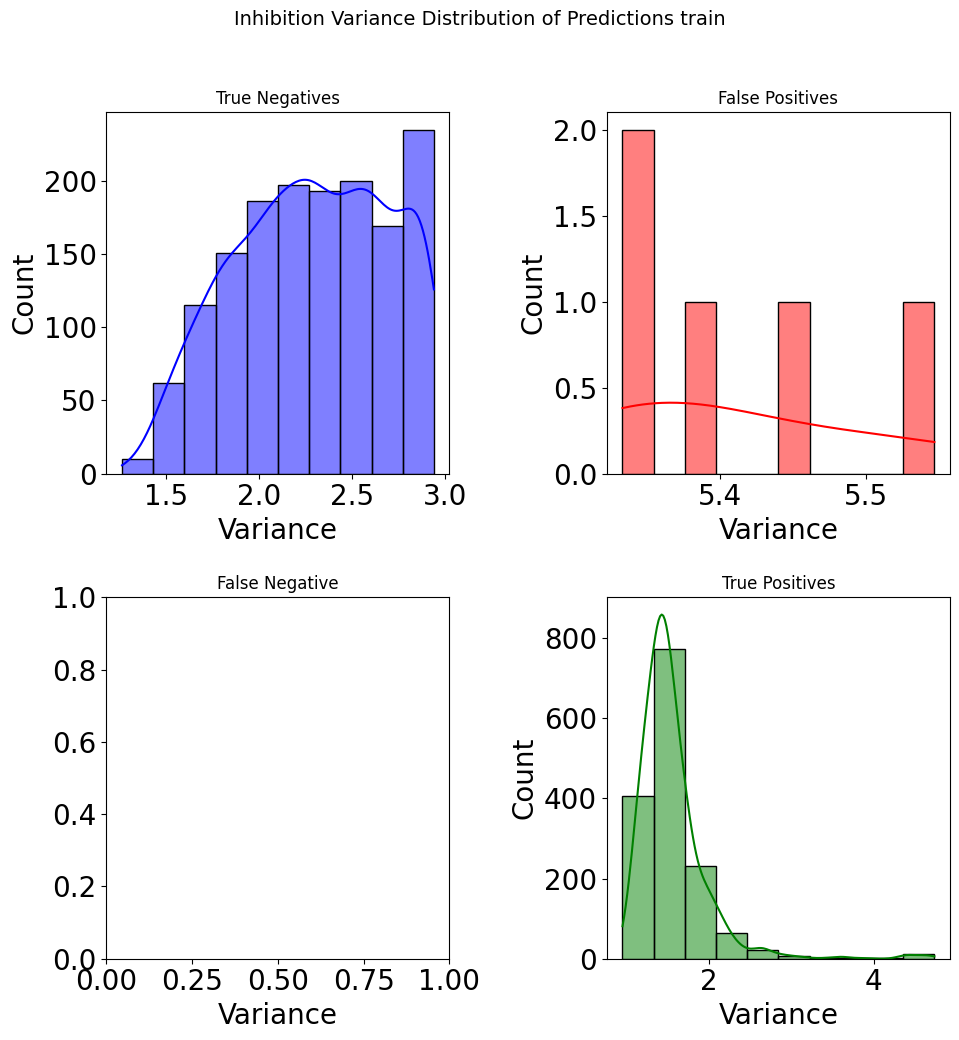

predictions shape: (409,)
true labels shape: (409,)


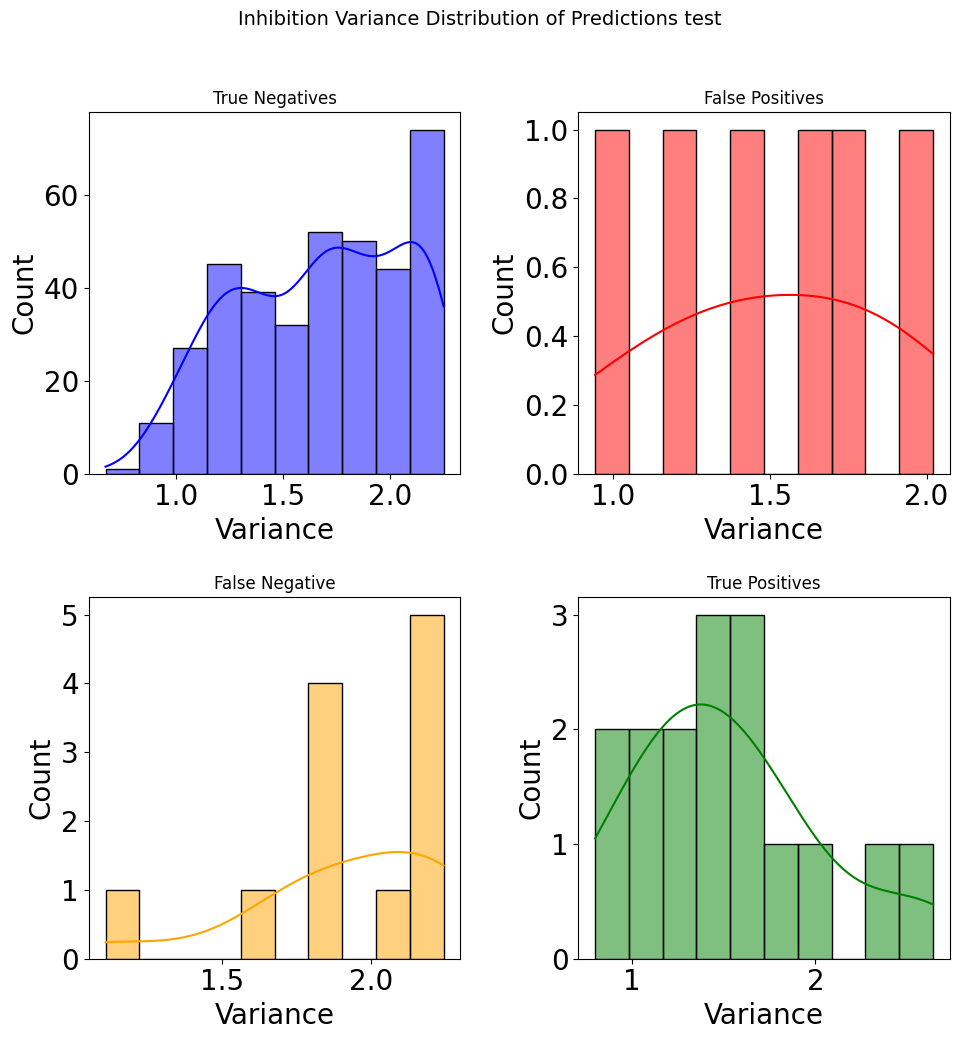

In [57]:
plot_cm_dist_kde(train_observed_pred, train_pred, train_y, 'train')
plot_cm_dist_kde(test_observed_pred, test_pred, test_y, 'test') 

predictions shape: (409,)
true labels shape: (409,)


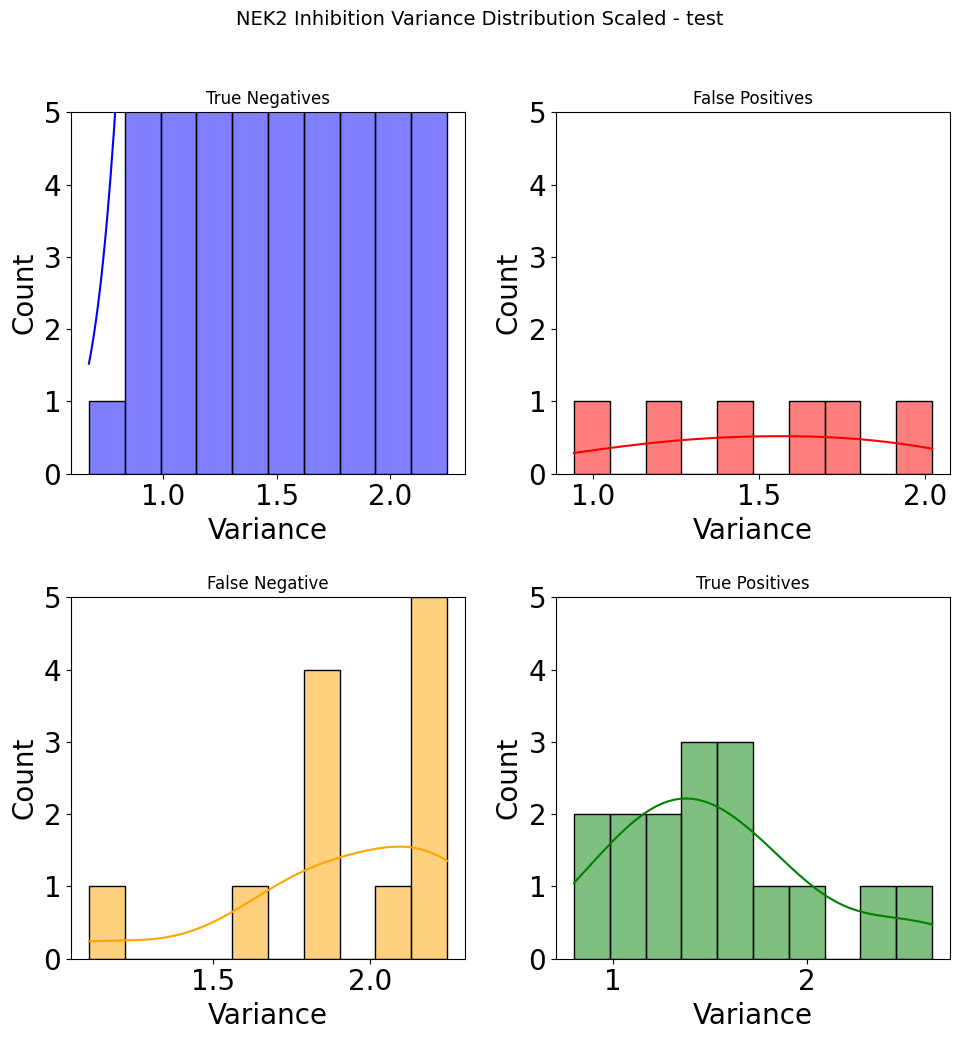

predictions shape: (409,)
true labels shape: (409,)


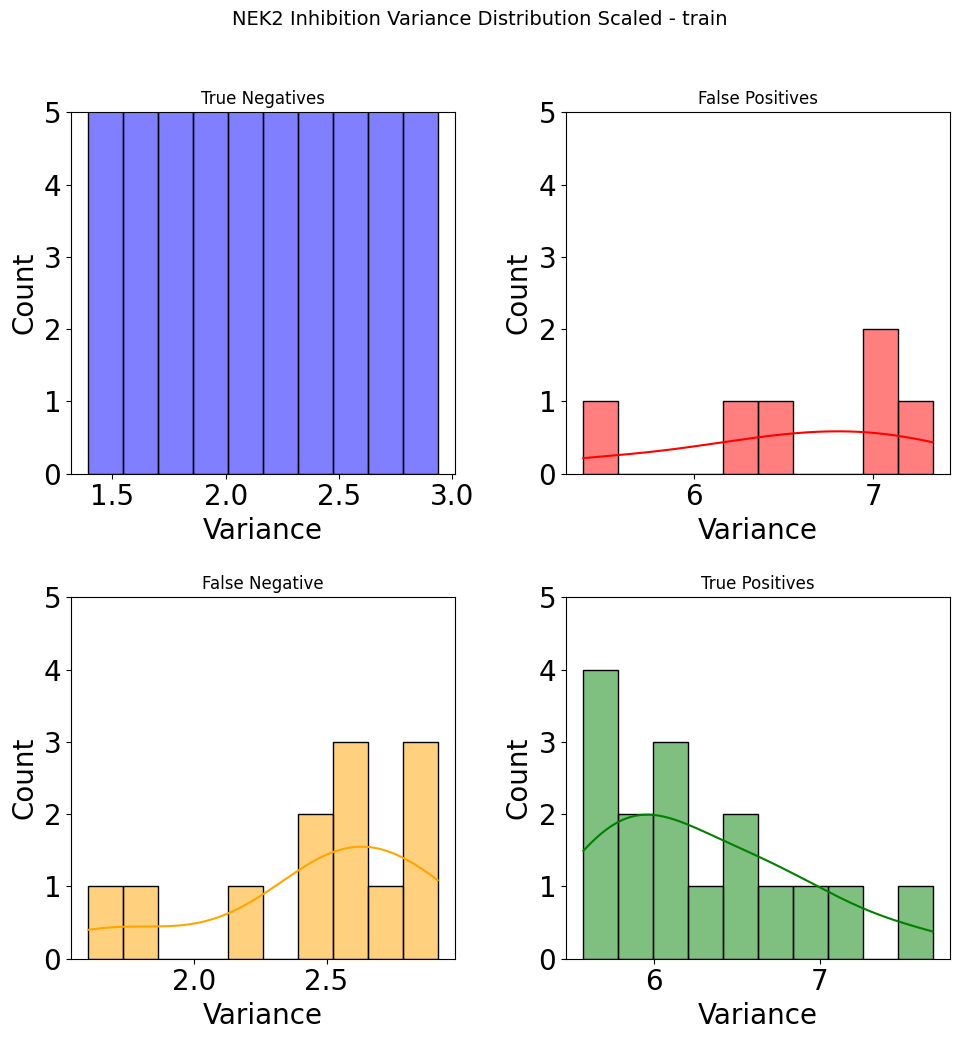

In [55]:
plot_cm_dist_kde_scaled(test_observed_pred, test_pred, test_y, 'test')
plot_cm_dist_kde_scaled(train_observed_pred, test_pred, test_y, 'train')

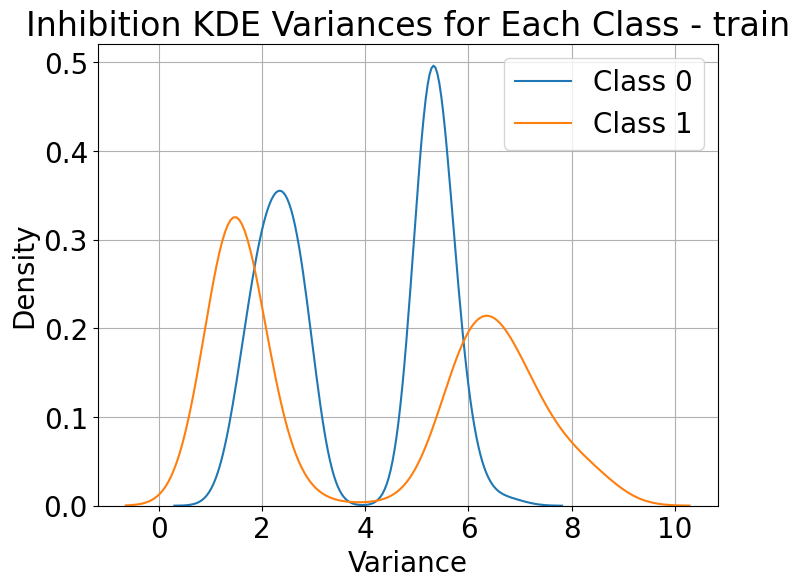

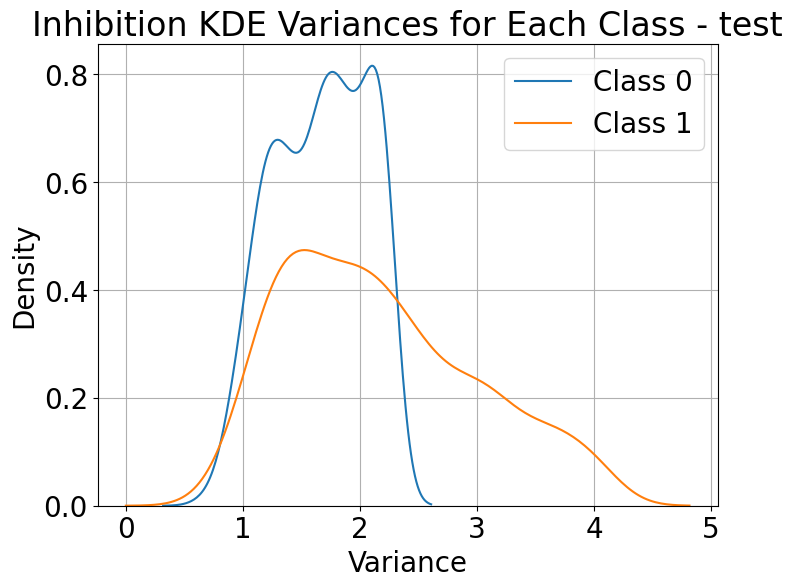

In [45]:
plot_kde(train_observed_pred, 'train')
plot_kde(test_observed_pred, 'test')
# plot_hist(test_observed_prt')

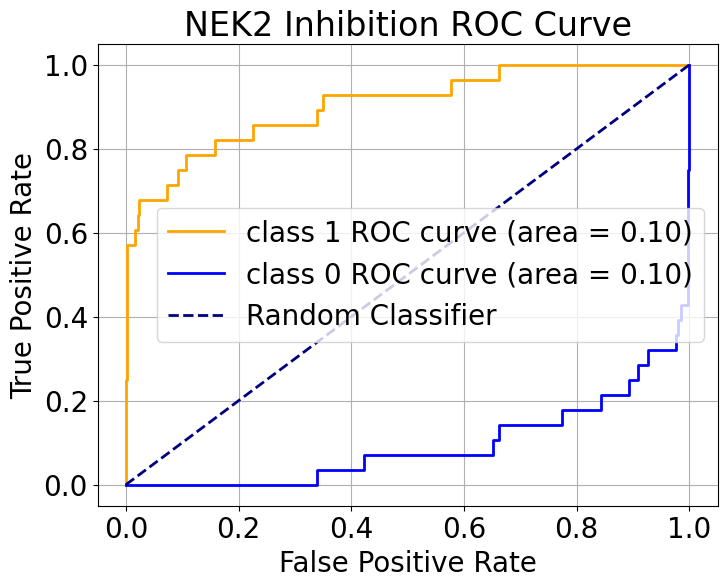

In [53]:
plot_roc(test_y, probabilities)

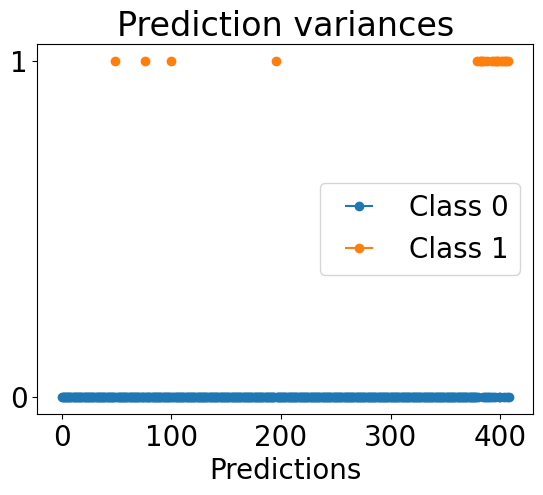

In [70]:
indices0 = np.where(test_pred == 0)[0]
indices1 = np.where(test_pred == 1)[0]

var_class0 = test_observed_pred.variance[0].numpy()
var_class1 = test_observed_pred.variance[1].numpy()
plt.errorbar(indices0, test_pred[indices0], 
             xerr=var_class0[indices0], fmt='o', label='Class 0')

plt.errorbar(indices1, test_pred[indices1], 
             xerr=var_class1[indices1], fmt='o', label='Class 1')


plt.xlabel('Predictions')
plt.yticks([0, 1], ['0', '1'])
plt.title('Prediction variances')
plt.legend()
plt.show()

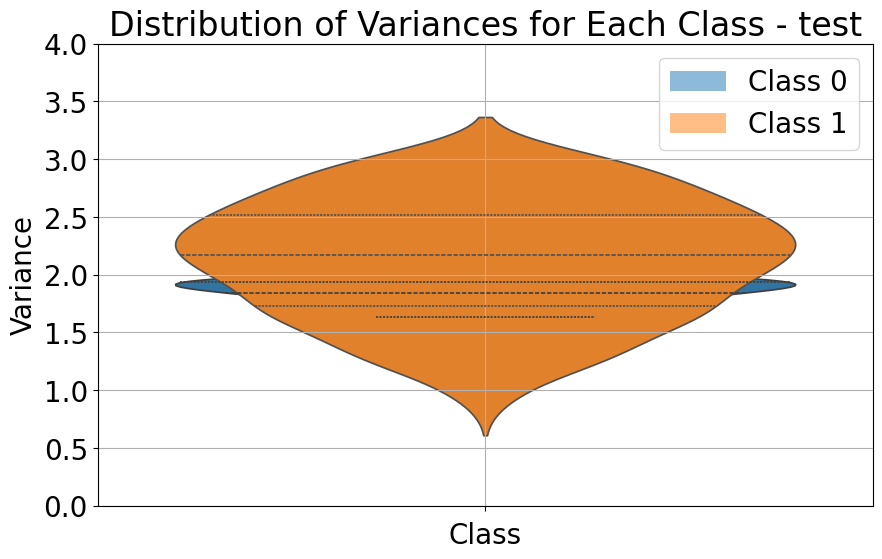

In [36]:
plot_violin(test_observed_pred, 'test', 4)

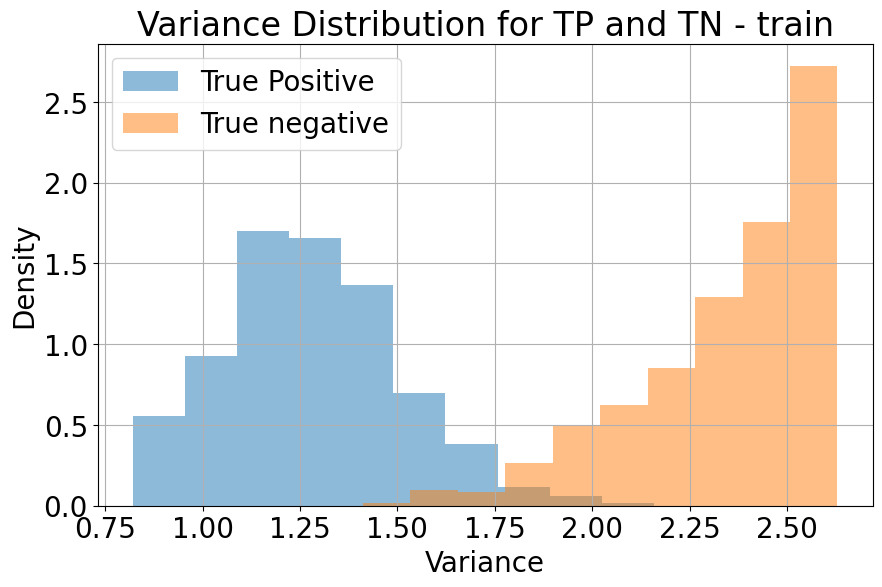

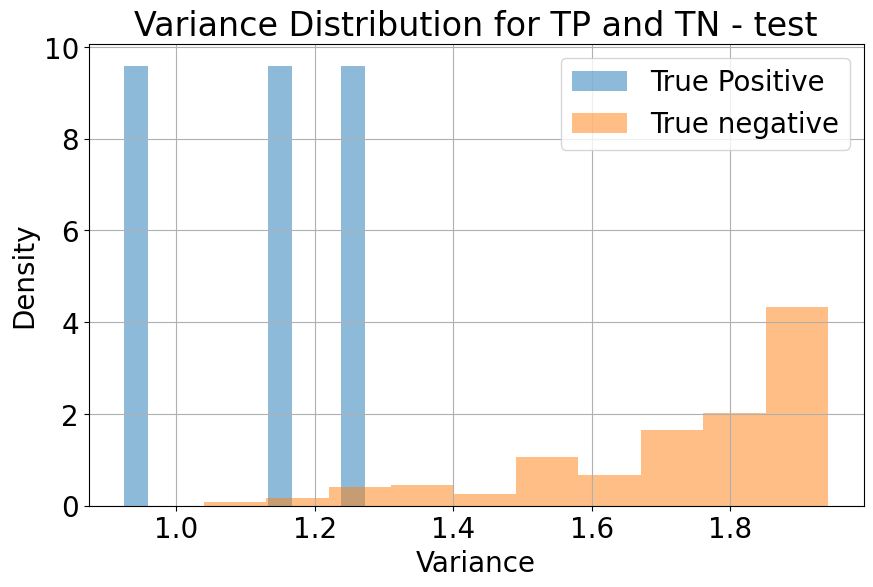

In [78]:
plot_hist_tp_tn(train_observed_pred, train_pred, train_y, 'train')
plot_hist_tp_tn(test_observed_pred, test_pred, test_y, 'test')

In [72]:
indices = np.where(test_pred == 1)[0]
# indices # array([136, 146, 273, 276, 282]) compared to: 
# tutorial: array([125, 136, 146, 273, 276, 282]) 

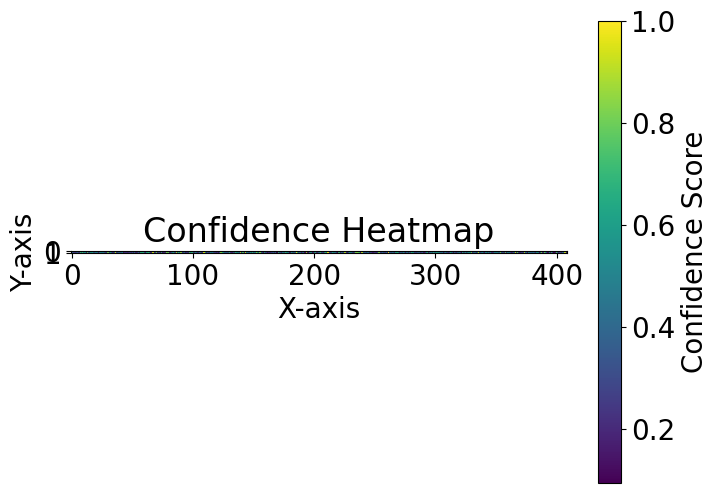

In [73]:
dist = trainer1.model(test_x)
pred_varainces = dist.variance
normalized = pred_varainces/pred_varainces.max() 
normalized.shape
plt.figure(figsize=(8, 6))
plt.imshow(normalized.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Confidence Score')
plt.title('Confidence Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [63]:
test_observed_pred.mean.numpy() # test_pred.mean.numpy()  observed_pred = self.likelihood(self.model(input)) 
# pred_means = dist.loc
test_pred_variance2D = test_observed_pred.variance.numpy()
print(test_observed_pred.variance.numpy().shape)
test_pred_variance2D
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_pred)]
# len(test_pred_variance)
# reshaped_pred_var = test_pred_variance2D
# reshaped_pred_var.shape
# test_x.shape, test_y.shape
# test_pred_variance

(2, 409)


In [75]:
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
print(var_min, var_max)


0.670224 4.0550594


In [77]:
# calibratio
from sklearn.calibration import calibration_curve
# n_bins = 10
# prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

# plt.figure(figsize=(8, 6))
# plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfectly calibrated line
# plt.xlabel('Predicted Probability')
# plt.ylabel('True Frequency')
# plt.title('Calibration Plot')
# plt.grid(True)
# plt.show(); 


In [64]:
with torch.no_grad(): 
    test_dist = model1(test_x)
    pred_means = test_dist.mean 
    pred_var = test_dist.variance
print(pred_var.shape)
# pred_var_reshaped = pred_var.reshape(2, -1)
# pred_var_reshaped.shape
# pred_var[1]

torch.Size([2, 409])


torch.Size([409, 409])
tensor([[1.1177, 1.1177, 1.1177,  ..., 1.1177, 1.1177, 1.1177],
        [1.3480, 1.3480, 1.3480,  ..., 1.3480, 1.3480, 1.3480],
        [0.8726, 0.8726, 0.8726,  ..., 0.8726, 0.8726, 0.8726],
        ...,
        [2.1832, 2.1832, 2.1832,  ..., 2.1832, 2.1832, 2.1832],
        [0.9318, 0.9318, 0.9318,  ..., 0.9318, 0.9318, 0.9318],
        [1.3221, 1.3221, 1.3221,  ..., 1.3221, 1.3221, 1.3221]])
torch.Size([409, 409])
tensor([[1.3186, 1.3186, 1.3186,  ..., 1.3186, 1.3186, 1.3186],
        [1.5988, 1.5988, 1.5988,  ..., 1.5988, 1.5988, 1.5988],
        [1.0650, 1.0650, 1.0650,  ..., 1.0650, 1.0650, 1.0650],
        ...,
        [3.7502, 3.7502, 3.7502,  ..., 3.7502, 3.7502, 3.7502],
        [0.8199, 0.8199, 0.8199,  ..., 0.8199, 0.8199, 0.8199],
        [1.4355, 1.4355, 1.4355,  ..., 1.4355, 1.4355, 1.4355]])


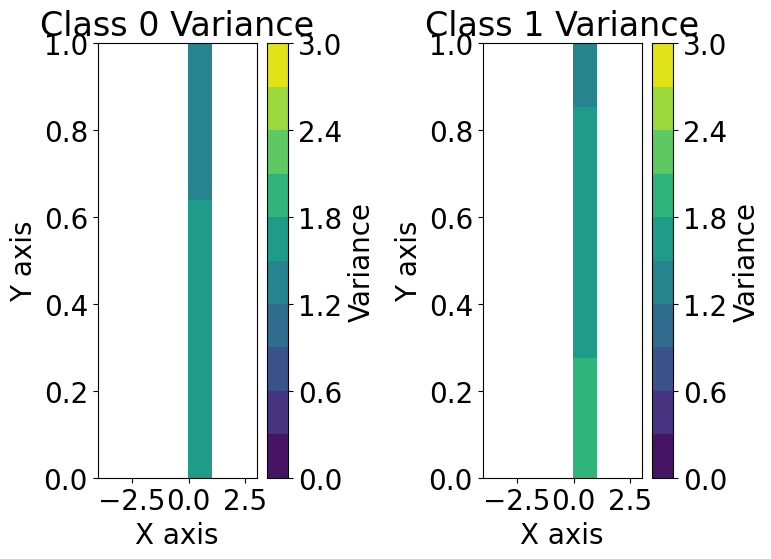

In [79]:
levels = np.linspace(0, 3, 11)
plt.figure(figsize=(8, 6))

x_values = test_x[:, 0].numpy()
y_values = test_y.numpy()
# y = np.linspace(test_y.min(), test_y.max(), 283)
x_mesh, y_mesh = np.meshgrid(x_values, y_values)

for class_idx in range(2):
    plt.subplot(1, 2, class_idx + 1)
    pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
    # print(pred_var_copy)
    # pred_var_reshaped = pred_var_copy.reshape((2, 283, 283))
    # plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

    pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
    # pred_var_copy = np.repeat(pred_var_copy[:, :, np.newaxis], x_mesh.shape[1], axis=2)
    print(pred_var_copy.shape)
    print(pred_var_copy)
    plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

    plt.colorbar(label='Variance')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(f'Class {class_idx} Variance')


plt.tight_layout()
plt.show();


In [46]:
samples = np.arange(len(test_x))
vars_class0 = test_pred_variance2D[0]
vars_class1 = test_pred_variance2D[1]

plt.figure(figsize=(8, 6))
plt.hexbin(samples, vars_class0, gridsize=50, cmap='tab20', label='Class 0')
plt.hexbin(samples, vars_class1, gridsize=50, cmap='tab10', label='Class 1')
plt.colorbar(label='Density')
plt.xlabel('Samples')
plt.ylabel('Variances')
plt.legend()
plt.show()


NameError: name 'test_pred_variance2D' is not defined

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_15644/1138995925.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


NameError: name 'test_pred_variance' is not defined

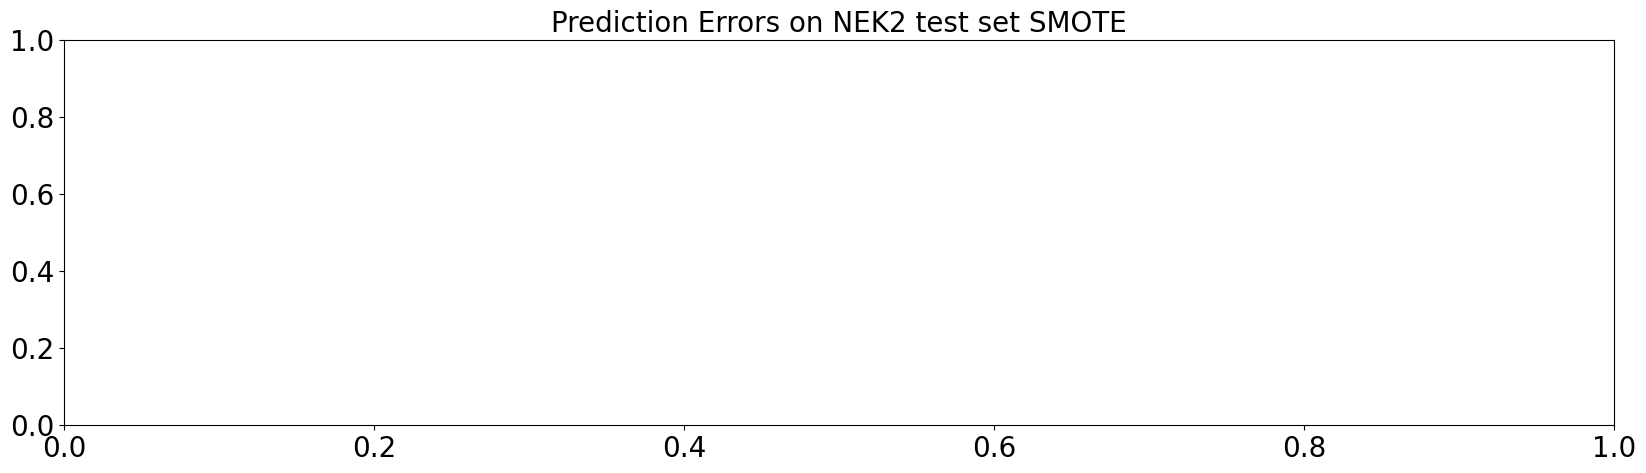

In [47]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance, s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_33767/3513342963.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


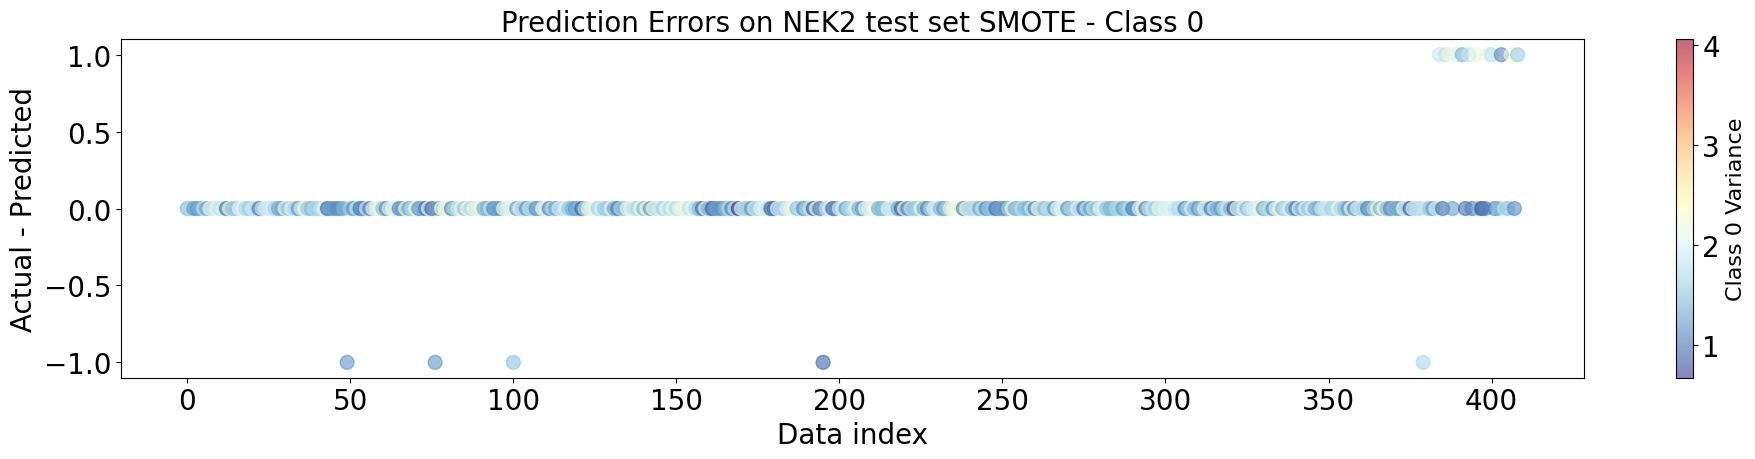

In [85]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 0",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[0], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 0 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_33767/3654803106.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


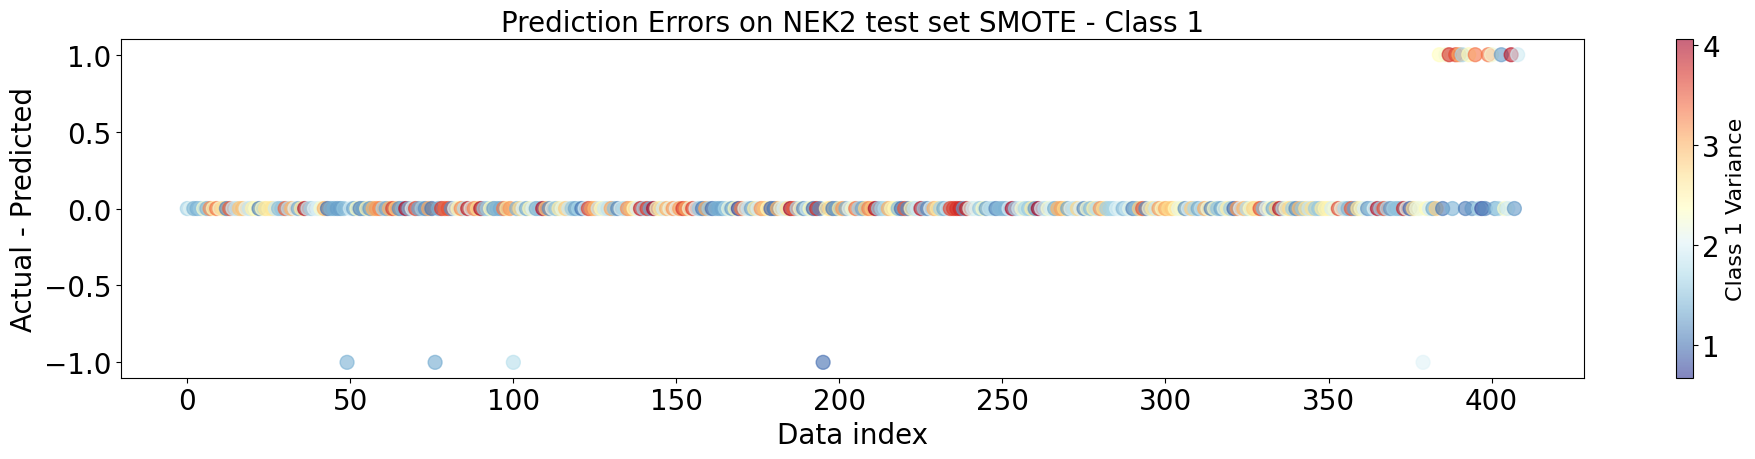

In [86]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 1",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[1], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 1 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

In [59]:
var_min = test_observed_pred.variance.numpy().min(axis=0).min()
var_max = test_observed_pred.variance.numpy().max(axis=0).max()
test_pred_variance2D=test_observed_pred.variance.numpy()
print(var_min, var_max)

0.6718544 4.0792027


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_15644/289335455.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


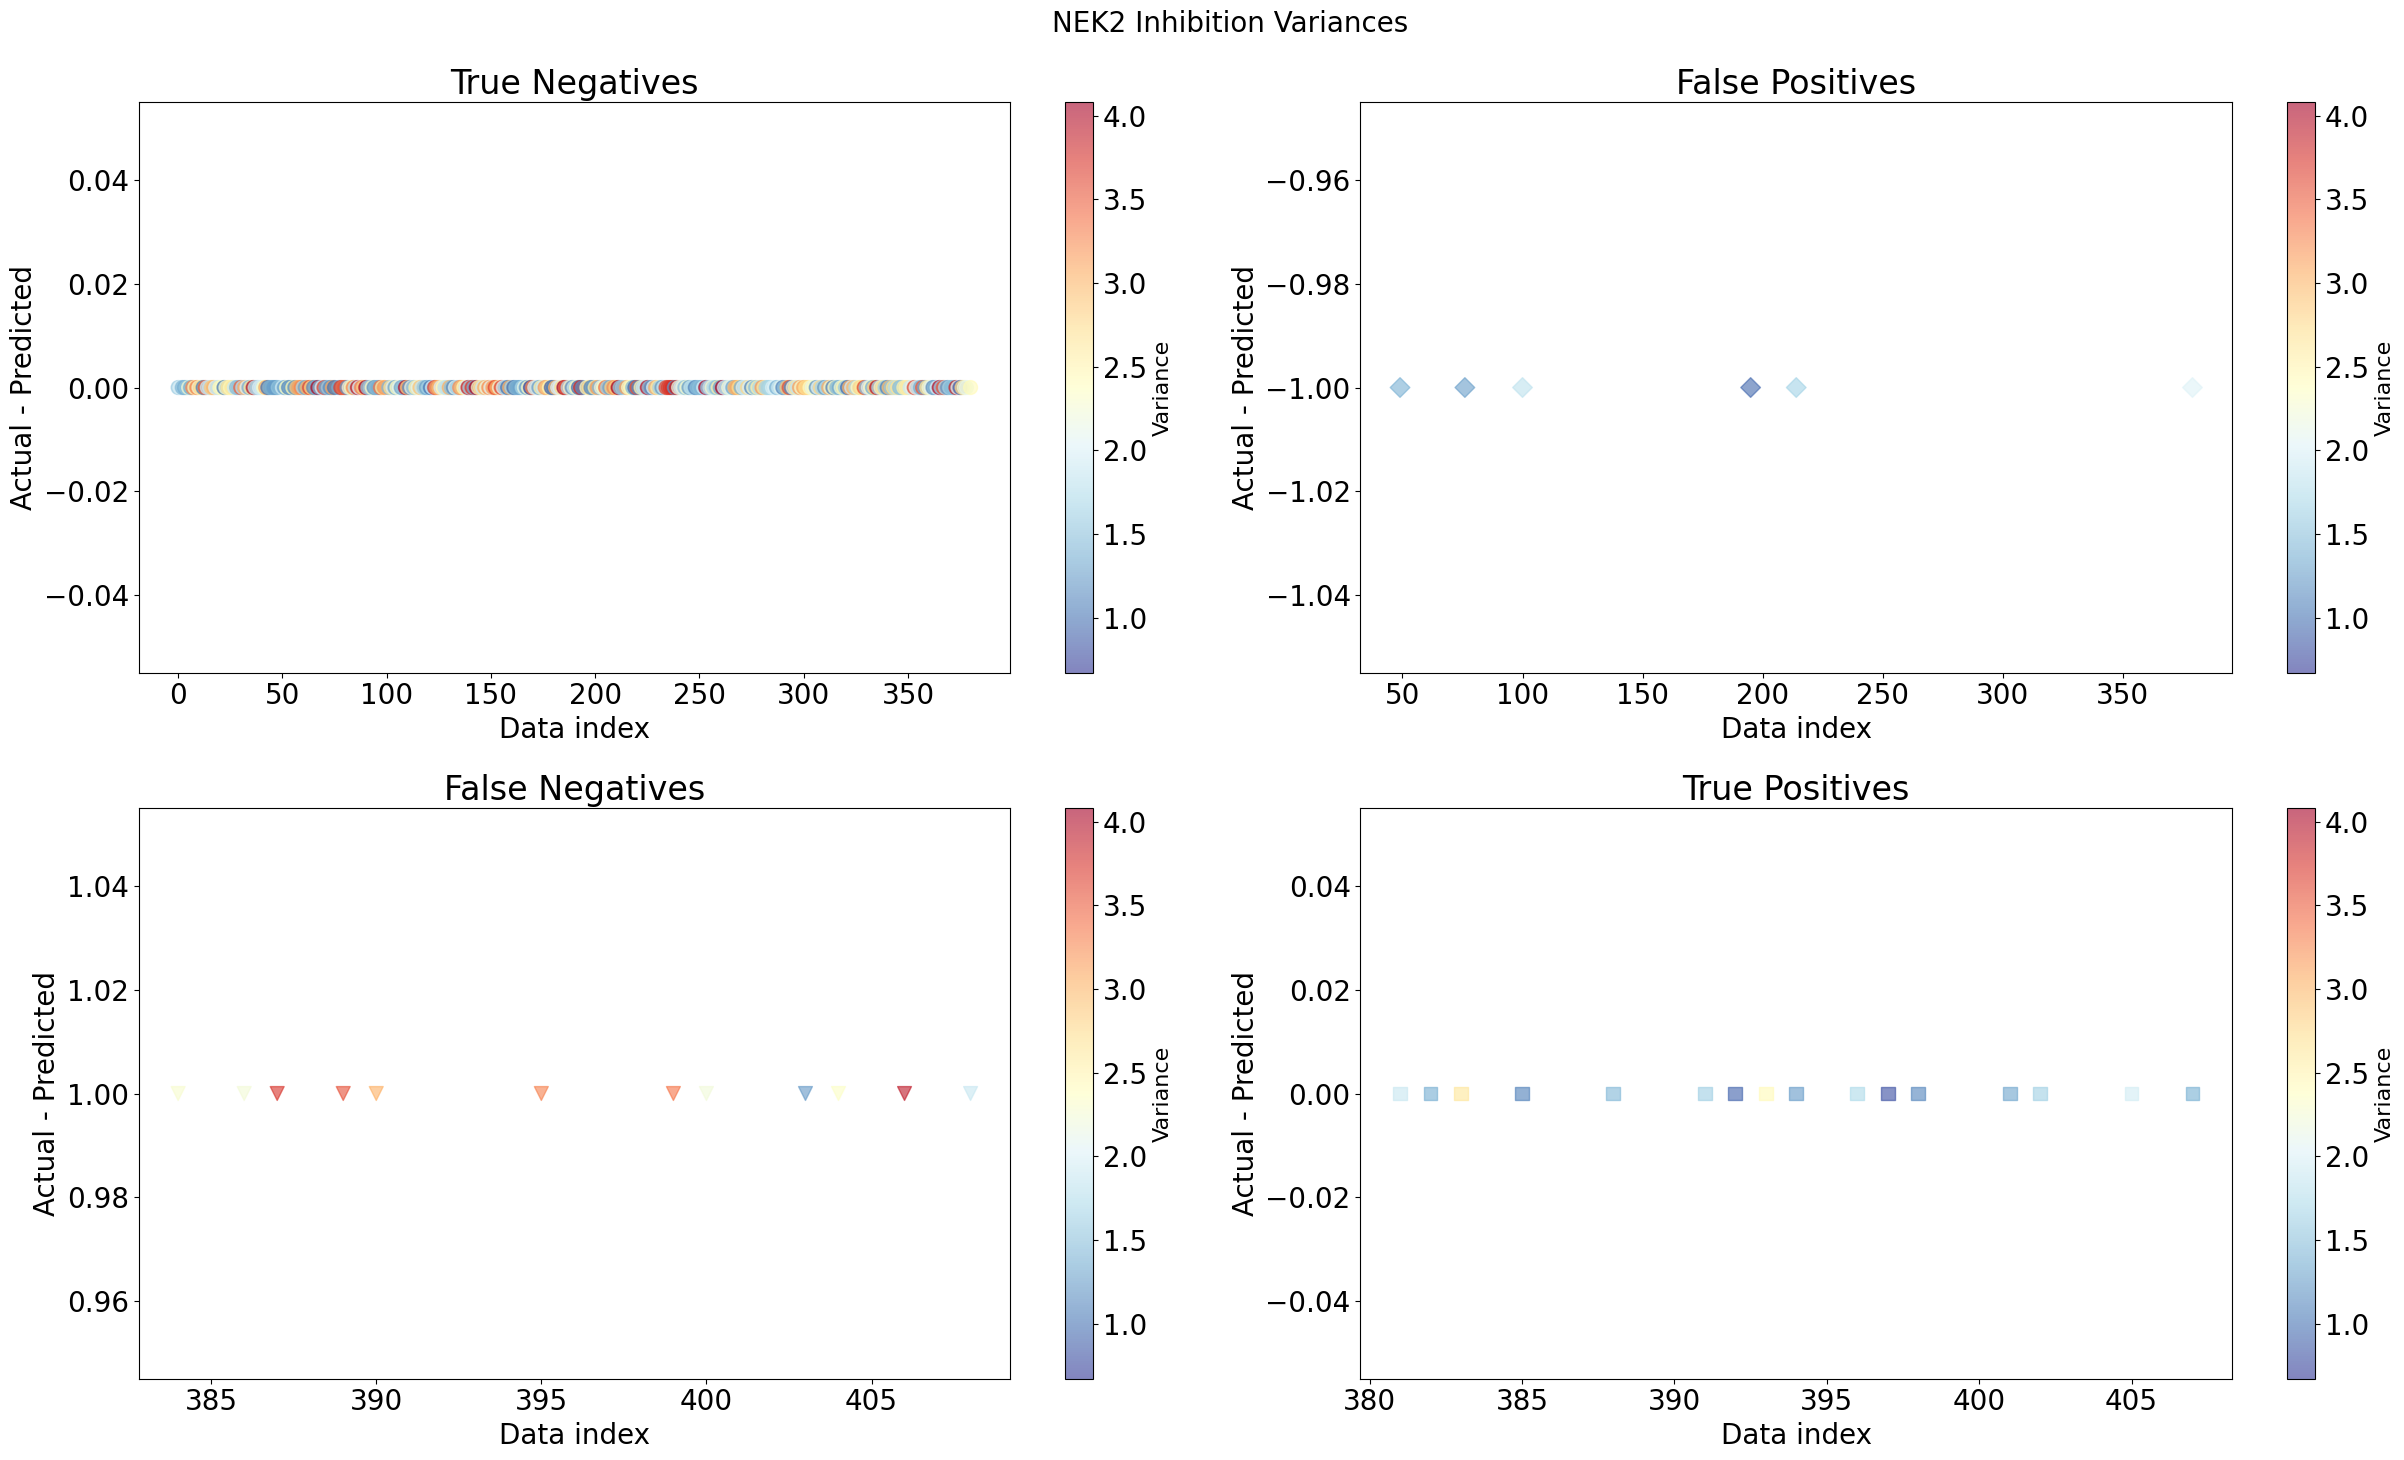

In [65]:
marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig, ax = plt.subplots(2, 2, figsize=(25, 15))
true_labels = test_y.numpy()


true_pos = np.where((test_pred == 1) & (true_labels == 1))[0] 
true_neg = np.where((test_pred == 0) & (true_labels == 0))[0]
false_pos = np.where((test_pred == 1) & (true_labels == 0))[0] 
false_neg = np.where((test_pred == 0) & (true_labels == 1))[0] 

var_tp = test_observed_pred.variance[1, true_pos].numpy()
var_tn = test_observed_pred.variance[0, true_neg].numpy()
var_fp = test_observed_pred.variance[1, false_pos].numpy()
var_fn = test_observed_pred.variance[0, false_neg].numpy()

sc_tp = ax[1, 1].scatter(true_pos, (test_y[true_pos] - test_pred[true_pos]), c=test_pred_variance2D[1, true_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[0])
ax[1, 1].set_title('True Positives')
ax[1, 1].set_xlabel('Data index')
ax[1, 1].set_ylabel('Actual - Predicted')


sc_tn = ax[0, 0].scatter(true_neg, (test_y[true_neg] - test_pred[true_neg]), c=test_pred_variance2D[1, true_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[1])
ax[0, 0].set_title('True Negatives')
ax[0, 0].set_xlabel('Data index')
ax[0, 0].set_ylabel('Actual - Predicted')


sc_fp = ax[0, 1].scatter(false_pos, (test_y[false_pos] - test_pred[false_pos]), c=test_pred_variance2D[1, false_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[2])
ax[0, 1].set_title('False Positives')
ax[0, 1].set_xlabel('Data index')
ax[0, 1].set_ylabel('Actual - Predicted')


sc_fn = ax[1, 0].scatter(false_neg, (test_y[false_neg] - test_pred[false_neg]), c=test_pred_variance2D[1, false_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[3])
ax[1, 0].set_title('False Negatives')
ax[1, 0].set_xlabel('Data index')
ax[1, 0].set_ylabel('Actual - Predicted')

cbar_tp = fig.colorbar(sc_tp, ax=ax[0, 0], location='right')
cbar_tp.set_label('Variance', fontsize=16)

cbar_tn = fig.colorbar(sc_tn, ax=ax[0, 1], location='right')
cbar_tn.set_label('Variance', fontsize=16)

cbar_fp = fig.colorbar(sc_fp, ax=ax[1, 0], location='right')
cbar_fp.set_label('Variance', fontsize=16)

cbar_fn = fig.colorbar(sc_fn, ax=ax[1, 1], location='right')
cbar_fn.set_label('Variance', fontsize=16)
plt.suptitle('NEK2 Inhibition Variances', fontsize=20)

# cbar.set_label('Variance', fontsize=16)

plt.tight_layout()

plt.savefig(f'nek2_inhib_scatter_dist_test.png')

plt.show()

In [77]:
test_pred_means.numpy().shape
test_prediction = test_dist.loc.max(0)[1].numpy()
y_true = test_y_df.values.flatten()
test_observed_pred.mean.numpy()
test_pred_variance2D = test_observed_pred.variance.numpy()

train_observed_pred.variance.numpy().shape
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_prediction)]
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities[0,]


train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()

train_perf_df["mean_pred_class0"] = train_observed_pred.mean.numpy()[0,]
train_perf_df["mean_pred_class1"] = train_observed_pred.mean.numpy()[1,]
train_perf_df["y"] = train_y
train_perf_df["y_pred"] = train_pred_means.max(0)[1]
train_perf_df["var_pred_class0"] = train_observed_pred.variance.numpy()[0,]
train_perf_df["var_pred_class1"] = train_observed_pred.variance.numpy()[1,]
train_perf_df['pred_probability_class0'] = train_probabilities.numpy()[0,]
train_perf_df['pred_probability_class1'] = train_probabilities.numpy()[1,]

test_perf_df["mean_pred_class0"] = test_observed_pred.mean.numpy()[0,]
test_perf_df["mean_pred_class1"] = test_observed_pred.mean.numpy()[1,]
test_perf_df["y"] = test_y
test_perf_df["y_pred"] = test_pred_means.max(0)[1]
test_perf_df["var_pred_class0"] = test_observed_pred.variance.numpy()[0,]
test_perf_df["var_pred_class1"] = test_observed_pred.variance.numpy()[1,]
test_perf_df['pred_probability_class0'] = probabilities.numpy()[0,]
test_perf_df['pred_probability_class1'] = probabilities.numpy()[1,]

test_perf_df

,mean_pred_class0,mean_pred_class1,y,y_pred,var_pred_class0,var_pred_class1,pred_probability_class0,pred_probability_class1
0,-0.556685,-6.587638,0,0,1.407539,1.587602,0.994207,0.005792
1,-0.034338,-6.171127,0,0,1.687300,2.003174,0.989066,0.010934
2,-0.512582,-6.549125,0,0,1.276645,1.436275,0.994445,0.005555
3,-0.943043,-4.869576,0,0,1.199017,1.369841,0.970859,0.029141
4,-0.135988,-7.055117,0,0,1.377362,1.540344,0.997519,0.002482
...,...,...,...,...,...,...,...,...
404,-2.721589,-2.924144,1,0,1.840502,2.348536,0.525037,0.474963
405,-3.993211,-1.810085,1,1,1.584154,1.948735,0.174819,0.825181
406,-0.245283,-6.652756,1,0,2.245698,3.915931,0.989686,0.010314
407,-3.884262,-1.865424,1,1,1.226347,1.374887,0.181845,0.818155


In [78]:
train_perf_df.to_csv("GPC_NEK2_Inhibition_train_perf.csv", index=False)
test_perf_df.to_csv("GPC_NEK2_Inhibition_test_perf.csv", index=False)

[381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398
 399 400 401 402 403 404 405 406 407 408]


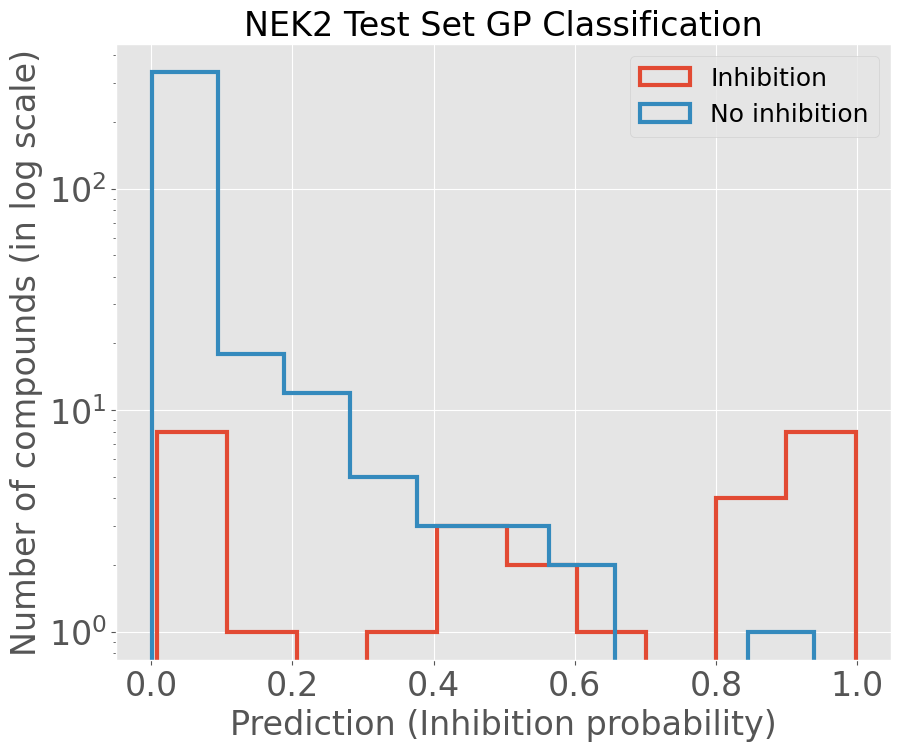

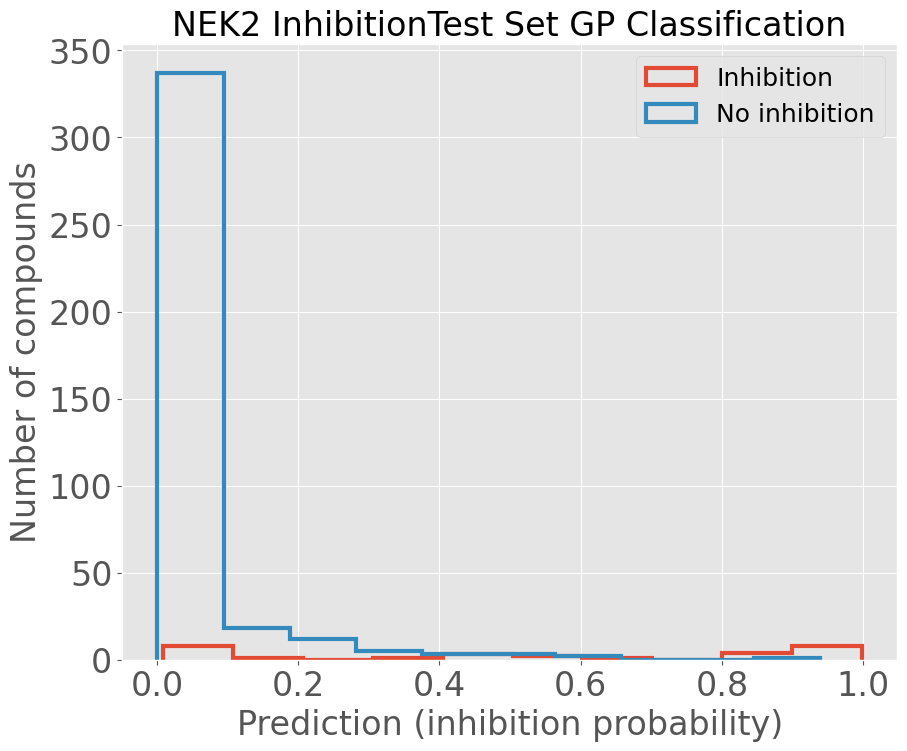

In [83]:
fig_width = 10
fig_height = 8

idx_1 = np.where(test_perf_df.y == 1)[0]
idx_0 = np.where(test_perf_df.y == 0)[0]

# Histogram predictions without error bars:
fig, ax = plt.subplots(1,figsize=(fig_width, fig_height))
ax.hist(test_perf_df.pred_probability_class1[idx_1], histtype='step', linewidth=3, label='Inhibition')
ax.hist(test_perf_df.pred_probability_class1[idx_0], histtype='step', linewidth=3, label='No inhibition')
ax.set_xlabel('Prediction (Inhibition probability)')
ax.set_ylabel('Number of compounds (in log scale)')
plt.title("NEK2 Test Set GP Classification", fontsize=24)
plt.legend(fontsize=18)
plt.yscale('log')
plt.savefig('NEK2_inhibition_hist_prob_log.png')

# Histogram predictions without error bars:
fig, ax = plt.subplots(1,figsize=(fig_width, fig_height))
ax.hist(test_perf_df.pred_probability_class1[idx_1], histtype='step', linewidth=3, label='Inhibition')
ax.hist(test_perf_df.pred_probability_class1[idx_0], histtype='step', linewidth=3, label='No inhibition')
ax.set_xlabel('Prediction (inhibition probability)')
ax.set_ylabel('Number of compounds')
plt.title("NEK2 InhibitionTest Set GP Classification", fontsize=24)
plt.legend(fontsize=18)
#plt.yscale('log')
print(idx_1)
plt.savefig('NEK2_inhibition_hist_prob.png')
plt.show()

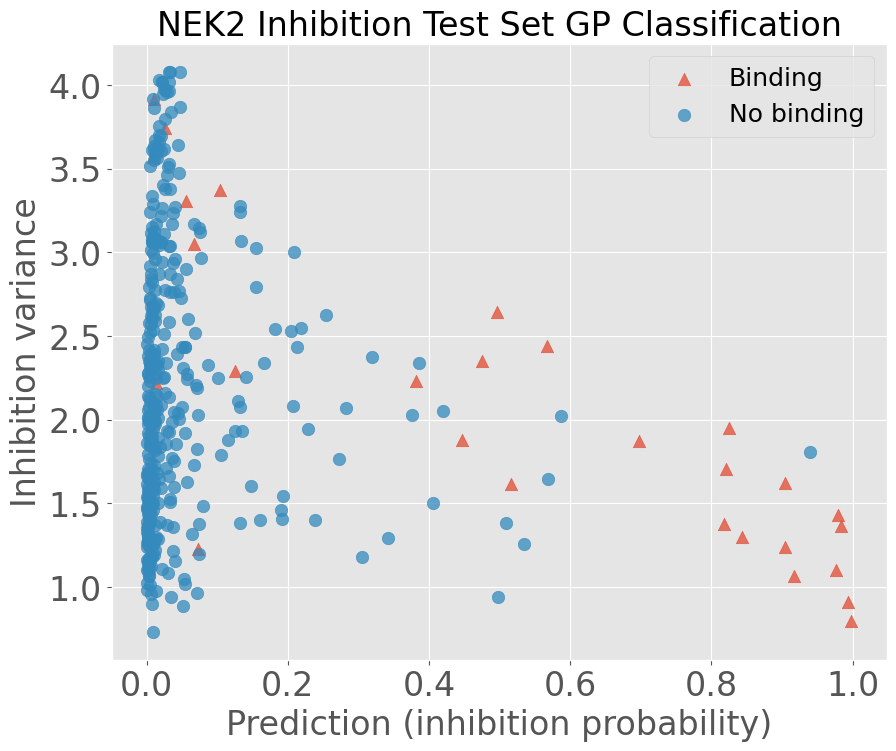

In [82]:

# Scatter plot
fig, ax = plt.subplots(1,figsize=(fig_width, fig_height))

ax.scatter(test_perf_df.pred_probability_class1[idx_1],
           test_perf_df.var_pred_class1[idx_1],
           label='Binding', marker='^', s=80, alpha=0.75)

ax.scatter(test_perf_df.pred_probability_class1[idx_0],
           test_perf_df.var_pred_class1[idx_0],
           label='No binding', marker='o', s=80, alpha=0.75)

ax.set_xlabel('Prediction (inhibition probability)')
ax.set_ylabel('Inhibition variance')
plt.title("NEK2 Inhibition Test Set GP Classification", fontsize=24)
plt.legend(fontsize=18)
plt.savefig('NEK2_inhibition_scatter_prob.png')

plt.show()


In [ ]:
# train_var = train_observed_pred.variance.numpy().tolist()
# plt.figure(figsize=(10, 6))
# for class_idx in range(2):
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')

# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.savefig('nek2train_hist.png')
# plt.show();


# plt.figure(figsize=(10, 6))
# for class_idx in range(2): 
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')
#     sns.violinplot(data=train_observed_pred.variance[class_idx].numpy().tolist(), inner="quartile")
# plt.xlabel('Class')

# plt.ylabel('Variance')
# plt.ylim(0,10)
# plt.legend()
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.grid(True)
# plt.show();

# plt.figure(figsize=(10, 6))
# for i in range(len(train_var)):
#     sns.kdeplot(train_var[i], label=f'Class {i}')
# plt.xlabel('Variance')
# plt.ylabel('Density')
# plt.title('KDE Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.show();

In [ ]:
# folds = [1] 
# for fold in folds: 
#     fold = str(fold)
#     trainx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainX.csv')
#     trainy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainY.csv')
#     testx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testX.csv')
#     testy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testY.csv')
#     # print(f'trainx :{trainx.shape}, trainy shape: {trainy.shape} \t testx: {testx.shape}, testy: {testy.shape}')
    
#     oversample_trial = SMOTE()
#     trial_train_x, trial_train_y_df = oversample_trial.fit_resample(trainx, trainy)
#     print(f'new trainx :{new_train_x_df.shape}, new trainy shape: {new_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'new trial trainx :{trial_train_x.shape}, new trial trainy shape: {trial_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'trial train same: {new_train_x_df.equals(trial_train_x)}')
#     print(f'test train same: {new_train_y_df.equals(trial_train_y_df)}')
#     print(f'trial test same: {test_x_df.equals(testx)}')
#     print(f'test test same: {test_y_df.equals(testy)}')
#     # print(list(new_train_x_df.values.flatten().tolist()))
#     # print(list(trial_train_x.values.flatten().tolist()))
#     diff_trainx = new_train_x_df.values != trial_train_x.values
#     which_diff_trainx = np.where(diff_trainx)
#     print(f"indices with differences in train x:", which_diff_trainx)
#     for i, val in enumerate(list(new_train_x_df.values.flatten().tolist())): 
#         other_val = list(trial_train_x.values.flatten().tolist())[i]
#         if (val != other_val): 
#             print(f'difference at index: {i}, new train y df: {val}, trial: {other_val}')
      
            